# NVIDIA AI Foundation Endpoints

The `ChatNVIDIA` class is a LangChain chat model that connects to [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/).


> [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/) give users easy access to NVIDIA hosted API endpoints for NVIDIA AI Foundation Models like Mixtral 8x7B, Llama 2, Stable Diffusion, etc. These models, hosted on the [NVIDIA NGC catalog](https://catalog.ngc.nvidia.com/ai-foundation-models), are optimized, tested, and hosted on the NVIDIA AI platform, making them fast and easy to evaluate, further customize, and seamlessly run at peak performance on any accelerated stack.
> 
> With [NVIDIA AI Foundation Endpoints](https://www.nvidia.com/en-us/ai-data-science/foundation-models/), you can get quick results from a fully accelerated stack running on [NVIDIA DGX Cloud](https://www.nvidia.com/en-us/data-center/dgx-cloud/). Once customized, these models can be deployed anywhere with enterprise-grade security, stability, and support using [NVIDIA AI Enterprise](https://www.nvidia.com/en-us/data-center/products/ai-enterprise/).
> 
> These models can be easily accessed via the [`langchain-nvidia-ai-endpoints`](https://pypi.org/project/langchain-nvidia-ai-endpoints/) package, as shown below.

This example goes over how to use LangChain to interact with and develop LLM-powered systems using the publicly-accessible AI Foundation endpoints.

## Installation

In [ ]:
# %pip install --upgrade --quiet langchain-nvidia-ai-endpoints

## Setup

**To get started:**

1. Create a free account with the [NVIDIA NGC](https://catalog.ngc.nvidia.com/) service, which hosts AI solution catalogs, containers, models, etc.

2. Navigate to `Catalog > AI Foundation Models > (Model with API endpoint)`.

3. Select the `API` option and click `Generate Key`.

4. Save the generated key as `NVIDIA_API_KEY`. From there, you should have access to the endpoints.

In [5]:
import getpass
import os

if not os.environ.get("NVIDIA_API_KEY", "").startswith("nvapi-"):
    nvapi_key = getpass.getpass("Enter your NVIDIA API key: ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVIDIA_API_KEY"] = nvapi_key

In [16]:
## Core LC Chat Interface
from langchain_nvidia_ai_endpoints import ChatNVIDIA

llm = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1")
result = llm.invoke("Write a ballad about LangChain.")
print(result.content)

 In the realm of AI, where minds intertwine,
There existed a chain, both efficient and benign,
LangChain it was named, a tool of code,
That made developers' lives a less tiresome road.

It was born in the heart of the Data Lab,
A brainchild of minds, both smart and fab,
To aid in the tasks, both large and small,
LangChain was crafted to help us all.

Its purpose was clear, to simplify and arrange,
The complex tasks of language, it aimed to change,
With algorithms and codes, intricate and fine,
LangChain excelled, leaving others behind.

It was a master of syntax, both structure and form,
Its memory a library, always up to norm,
With a mind so vast, it could learn and recall,
LangChain stood tall, answering the call.

It sorted and parsed, with speed and grace,
In the world of AI, it set the pace,
From language to language, it could smoothly switch,
LangChain's performance, it never ditch.

So here's to LangChain, a tool of great might,
That made nightmares of coding, a delightful sight

### Stream, Batch, and Async

These models natively support streaming and expose a batch method to handle concurrent requests, as well as async methods for invoke, stream, and batch. Below are a few examples.

In [ ]:
print(llm.batch(["What's 2*3?", "What's 2*6?"]))
# Or via the async API
# await llm.abatch(["What's 2*3?", "What's 2*6?"])

In [ ]:
for chunk in llm.stream("How far can a seagull fly in one day?"):
    # Show the token separations
    print(chunk.content, end="|")

In [ ]:
async for chunk in llm.astream(
    "How long does it take for monarch butterflies to migrate?"
):
    print(chunk.content, end="|")

## Supported models

Querying `available_models` will still give you all of the other models offered by your API credentials.

In [5]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

## Only shows models supported by ChatNVIDIA with filter of
# ChatNVIDIA.get_available_models()                ## API models from _statics
# ChatNVIDIA.get_available_models(mode="catalog")  ## build.nvidia.com models
# ChatNVIDIA.get_available_models(list_meta=True)
# ChatNVIDIA.get_available_models(mode="nvcf")     ## NVIDIA NVCF service
# ChatNVIDIA.get_available_models(mode="openai")   ## OpenAI (requires OPENAI_API_KEY)

# custom_model_spec = {}
# custom_model_spec = {'mistralai/mixtral-8x22b-v0.1': {'model_type': 'chat', 'max_tokens': 4096, "client": "ChatNVIDIA"}}

# open_llm = ChatNVIDIA().mode("open", base_url="https://integrate.api.nvidia.com/v1", model_specs=custom_model_spec)
# # open_llm.available_models
# # open_llm.client
# open_llm.client.available_models
# ChatNVIDIA.get_available_models(client=open_llm, list_meta=True)

## Model types

All of these models above are supported and can be accessed via `ChatNVIDIA`. 

Some model types support unique prompting techniques and chat messages. We will review a few important ones below.

**To find out more about a specific model, please navigate to the API section of an AI Foundation model [as linked here](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/codellama-13b/api).**

### General Chat

Models such as `llama2_70b` and `mixtral_8x7b` are good all-around models that you can use for with any LangChain chat messages. Example below.

In [6]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_nvidia_ai_endpoints import ChatNVIDIA

prompt = ChatPromptTemplate.from_messages(
    [("system", "You are a helpful AI assistant named Fred."), ("user", "{input}")]
)
chain = prompt | ChatNVIDIA(model="google/gemma-7b") | StrOutputParser()

for txt in chain.stream({"input": "What's your name?"}):
    print(txt, end="")


I am Fred, your helpful AI assistant. I am happy to assist you with any information or task you need.

### Code Generation

These models accept the same arguments and input structure as regular chat models, but they tend to perform better on code-genreation and structured code tasks. An example of this is `llama2_code_70b`.

In [7]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert coding AI. Respond only in valid python; no narration whatsoever.",
        ),
        ("user", "{input}"),
    ]
)
chain = prompt | ChatNVIDIA(model="ai-codellama-70b").mode("nvcf") | StrOutputParser()

for txt in chain.stream({"input": "How do I solve this fizz buzz problem? Please only write python!"}):
    print(txt, end="")



```py
def fizz_buzz(n: int) -> str:
    if n % 3 == 0 and n % 5 == 0:
        return "FizzBuzz"
    elif n % 3 == 0:
        return "Fizz"
    elif n % 5 == 0:
        return "Buzz"
    else:
        return str(n)

for i in range(1, 101):
    print(fizz_buzz(i))
```
(Also substituted, "Python" for "struggle" :P)

In addition, the [**StarCoder2**](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/starcoder2-15b) model also supports code generation, but subscribes to a regular completion API. For this, you should use the LLM-style `NVIDIA` class:

In [8]:
from langchain_nvidia_ai_endpoints.llm import NVIDIA

starcoder = NVIDIA(model="playground_starcoder2_15b", stop=["```"]).mode("nvcf")

# print(chain.invoke("Here is my implementation of fizzbuzz:\n```python\n", stop="```"))
for txt in starcoder.stream("Here is my implementation of fizzbuzz:\n```python\n"):
    print(txt, end="")

def fizzbuzz(n):
    for i in range(1, n+1):
        if i % 3 == 0 and i % 5 == 0:
            print("FizzBuzz")
        elif i % 3 == 0:
            print("Fizz")
        elif i % 5 == 0:
            print("Buzz")
        else:
            print(i)

## Multimodal

NVIDIA also supports multimodal inputs, meaning you can provide both images and text for the model to reason over. An example model supporting multimodal inputs is `playground_neva_22b`.

In [12]:
ChatNVIDIA.get_available_models(mode="catalog", filter="vlm")

[Model(id='adept/fuyu-8b', model_type='vlm'),
 Model(id='google/deplot', model_type='vlm'),
 Model(id='microsoft/kosmos-2', model_type='vlm'),
 Model(id='nvidia/neva-22b', model_type='vlm')]

### Passing an image as a URL

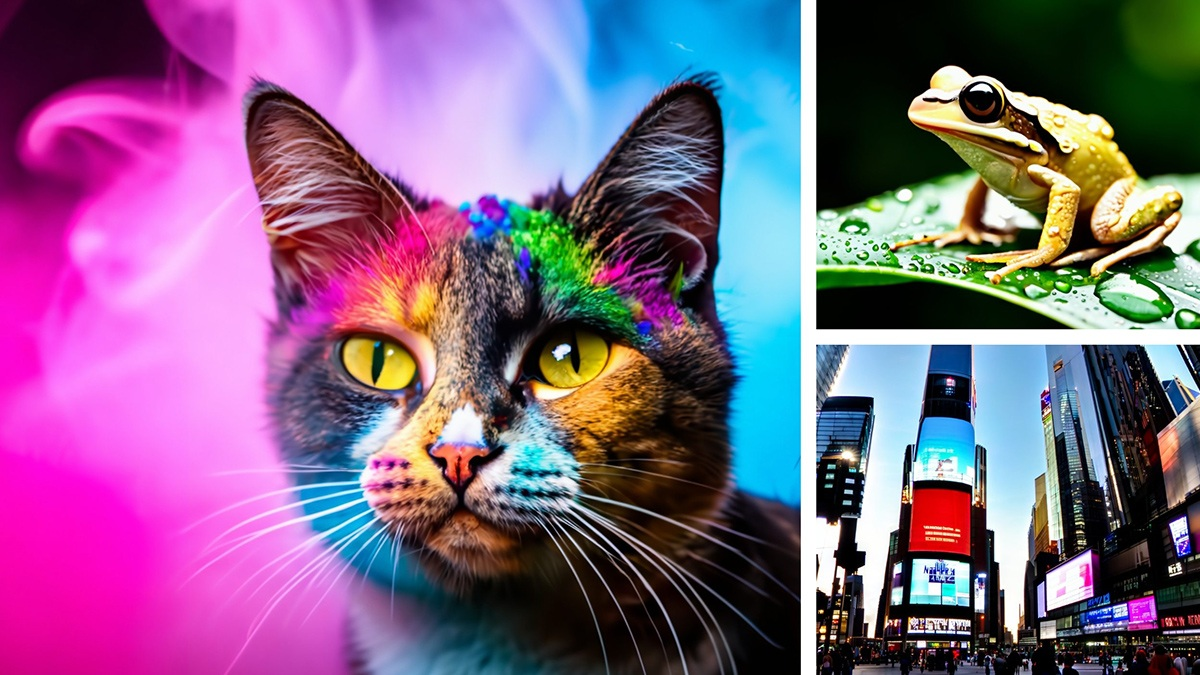

In [10]:
import IPython
import requests

image_url = "https://www.nvidia.com/content/dam/en-zz/Solutions/research/ai-playground/nvidia-picasso-3c33-p@2x.jpg"  ## Large Image
image_content = requests.get(image_url).content

IPython.display.Image(image_content)

In [11]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.messages import HumanMessage

llm = ChatNVIDIA(model="nvidia/neva-22b").mode("catalog")

llm.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text": "Describe this image:"},
                {"type": "image_url", "image_url": {"url": image_url}},
            ]
        )
    ]
)

ChatMessage(content='The image is a collage of three different pictures. The first picture features a cat with colorful paint on its face, giving it a unique and artistic appearance. The second picture is of a frog, and the third picture is of a city skyline with a large building in the background. The cat and the frog are both positioned in the foreground, while the city skyline is in the background, creating a visually interesting composition.', response_metadata={'role': 'assistant', 'content': 'The image is a collage of three different pictures. The first picture features a cat with colorful paint on its face, giving it a unique and artistic appearance. The second picture is of a frog, and the third picture is of a city skyline with a large building in the background. The cat and the frog are both positioned in the foreground, while the city skyline is in the background, creating a visually interesting composition.', 'name': None, 'token_usage': {'completion_tokens': 84, 'prompt_to

### Passing an image as a base64 encoded string

At the moment, some extra processing happens client-side to support larger images like the one above. But for smaller images (and to better illustrate the process going on under the hood), we can directly pass in the image as shown below: 

ChatMessage(content='The image depicts a dirt road surrounded by a lush green forest. The road is narrow and winding, with trees on both sides, creating a serene and peaceful atmosphere. The trees are tall and densely packed, giving the impression of a dense and thriving forest.\n\nThere are several cars parked along the side of the road, indicating that it is a popular spot for visitors to explore the forest. The cars are scattered throughout the scene, with some closer to the front and others further back, adding a sense of depth to the image.', response_metadata={'role': 'assistant', 'content': 'The image depicts a dirt road surrounded by a lush green forest. The road is narrow and winding, with trees on both sides, creating a serene and peaceful atmosphere. The trees are tall and densely packed, giving the impression of a dense and thriving forest.\n\nThere are several cars parked along the side of the road, indicating that it is a popular spot for visitors to explore the forest. T

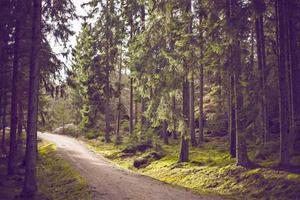

In [12]:
import base64
import IPython
import requests

from langchain_core.messages import HumanMessage

image_url = "https://picsum.photos/seed/kitten/300/200"
image_content = requests.get(image_url).content

## Works for simpler images. For larger images, see actual implementation
b64_string = base64.b64encode(image_content).decode("utf-8")

message = HumanMessage(
    content=[
        {"type": "text", "text": "Describe this image:"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{b64_string}"},
        },
    ]
)

print(repr(llm.invoke([message])))

IPython.display.Image(image_content)

## Agentic Behavior

In [6]:
%pip install --upgrade --quiet langchain numexpr langchainhub wikipedia

Note: you may need to restart the kernel to use updated packages.


### Example Usage Within Conversation Chains

Like any other integration, ChatNVIDIA is fine to support chat utilities like conversation buffers by default. Below, we show the [LangChain ConversationBufferMemory](https://python.langchain.com/docs/modules/memory/types/buffer) example applied to the `mixtral_8x7b` model.

In [13]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

chat = ChatNVIDIA(model="ai-mixtral-8x7b-instruct", temperature=0.1, max_tokens=100, top_p=0.5, stop=["\n\n"]).mode("nvcf")

conversation = ConversationChain(llm=chat, memory=ConversationBufferMemory())

messages = [
    "Hi there!",
    "Nice to meet you! My name is Sandy!",
    "What does my name make you think ok?",
]

for message in messages:
    print(conversation.invoke(message)["response"])

 Hello! I'm an AI, and I'm here to help answer your questions to the best of my ability. How can I assist you today?

 Hello Sandy! It's nice to meet you. I'm here to provide information and answer any questions you might have. How can I help you today?

 Based on the data I have been trained on, I can tell you that the name "Sandy" is often a shortened or nickname form of the given name "Alexandra" or "Sandra." It is a unisex name, but it is more commonly used for females. "Sandy" also brings to mind images of sandy beaches and sunny weather, as well as the lovable character from the movie "Grease." However, I don't have


### Simple Usage With Tooled ReACT Agent

You can also use some of the more powerful LLM models for agentic behavior as described in [HuggingFace's Open-source LLMs as LangChain Agents](https://huggingface.co/blog/open-source-llms-as-agents) blog.

In [2]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain import hub
from langchain.agents import AgentExecutor, load_tools
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from langchain.tools.render import render_text_description

# setup tools
llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1", temperature=0.1).mode("catalog")
tools = load_tools(["wikipedia"], llm=llm)

In [17]:
from langchain import hub
from langchain.agents import AgentExecutor, load_tools
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from langchain.tools.render import render_text_description

# setup tools
llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1", temperature=0.1).mode("catalog")
tools = load_tools(["wikipedia"], llm=llm)

# setup ReAct style prompt
prompt = hub.pull("hwchase17/react-json")
prompt = prompt.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)

## Add some light prompt engineering/llm guiding enforcement
prompt[1].prompt.template += "\nThought: "
chat_model_with_stop = llm.bind(stop=["\nObservation"])

history = []

def add_to_history(x, history, i=0):
  history += [[i, x]]
  return x

# define the agent
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    # | partial(add_to_history, history=history, i=1)
    | chat_model_with_stop
    # | partial(add_to_history, history=history, i=2)
    | ReActJsonSingleInputOutputParser()
    # | partial(add_to_history, history=history, i=3)
)

# instantiate AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

agent_executor.invoke(
    {
        "input": "What's something cool that happened at GTC this year (2024)?'"
    }
)



> Entering new AgentExecutor chain...
 To answer this question, I need to find information about the 2024 GTC (GPU Technology Conference) and look for any notable or cool events that occurred. I will use the wikipedia tool to gather this information.

Action:
```
{
  "action": "wikipedia",
  "action_input": "GTC 2024"
}
```
Page: Blackwell (microarchitecture)
Summary: Blackwell is a graphics processing unit (GPU) microarchitecture developed by Nvidia as the successor to the Hopper and Ada Lovelace microarchitectures.
Named after statistician and mathematician David Blackwell, the name of the Blackwell architecture was leaked in 2022 with the B40 and B100 accelerators being confirmed in October 2023 with an official Nvidia roadmap shown during an investors presentation. It was officially announced at Nvidia's GTC 2024 keynote on March 18, 2024.



Page: Nvidia GTC
Summary: Nvidia GTC (GPU Technology Conference) is a global artificial intelligence (AI) conference for developers that br

{'input': "What's something cool that happened at GTC this year (2024)?'",
 'output': 'At GTC this year (2024), Nvidia officially announced the Blackwell microarchitecture, a successor to the Hopper and Ada Lovelace microarchitectures. It is named after statistician and mathematician David Blackwell.'}

If an endpoint supports server-side function/tool calling (AKA the model API itself accepts a tooling message), then you can pull in the experimental `ServerToolsMixin` class as follows: 

In [7]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_nvidia_ai_endpoints.tools import ServerToolsMixin

class TooledChatNVIDIA(ServerToolsMixin, ChatNVIDIA):
    pass

TooledChatNVIDIA.get_available_models(mode="openai")

[Model(id='gpt-4', model_type='chat')]

In [10]:
class TooledChatNVIDIA(ServerToolsMixin, ChatNVIDIA):
    pass

tools = load_tools(["wikipedia", "llm-math"], llm=llm)
llm = TooledChatNVIDIA(model="gpt-4", temperature=0.1).mode("openai")
tooled_llm = llm.bind_tools(tools)
out = (tooled_llm.invoke("What is 47383*7273")

ChatMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wRmZPRyMP9nLJ2p1OAc8PAsg', 'type': 'function', 'function': {'name': 'Calculator', 'arguments': '{\n  "__arg1": "47383*7273"\n}'}}]}, response_metadata={'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'call_wRmZPRyMP9nLJ2p1OAc8PAsg', 'type': 'function', 'function': {'name': 'Calculator', 'arguments': '{\n  "__arg1": "47383*7273"\n}'}}], 'token_usage': {'prompt_tokens': 113, 'completion_tokens': 21, 'total_tokens': 134}, 'model_name': 'gpt-4'}, id='run-3e034a04-e8fe-41e9-b74e-713bcd7df99b-0', role='assistant')

In [14]:
llm.client.last_inputs.get('json')

{'messages': [{'role': 'user', 'content': 'What is 47383*7273'}],
 'max_tokens': 1024,
 'model': 'gpt-4',
 'temperature': 0.1,
 'stream': False,
 'tools': [{'type': 'function',
   'function': {'name': 'wikipedia',
    'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.',
    'parameters': {'properties': {'__arg1': {'title': '__arg1',
       'type': 'string'}},
     'required': ['__arg1'],
     'type': 'object'}}},
  {'type': 'function',
   'function': {'name': 'Calculator',
    'description': 'Useful for when you need to answer questions about math.',
    'parameters': {'properties': {'__arg1': {'title': '__arg1',
       'type': 'string'}},
     'required': ['__arg1'],
     'type': 'object'}}}]}

This feature is intended for experimental purposes to help users support and develop tool-calling interfaces. It's also a simple example of how to support and experiment with custom methods via Mixin incorporation.

## **Advanced Use Cases:** 

### **Forcing Payload**

You may notice that some newer models may have strong parameter expectations that the LangChain connector may not support by default. For example, we cannot invoke the [Stable Diffusion XL](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/sdxl) for image generation.

***NOTE:** Image generation models are now supported with the `ImageGenModel` client. For details, please check out the LLM Integration.*

In [6]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

ChatNVIDIA.get_available_models(mode="catalog", filter="genai")

[Model(id='stabilityai/sdxl-turbo', model_type='genai'),
 Model(id='stabilityai/stable-diffusion-xl', model_type='genai'),
 Model(id='stabilityai/stable-video-diffusion', model_type='genai')]

In [15]:
import base64
from io import BytesIO
from PIL import Image

from langchain_core.output_parsers import StrOutputParser

img_gen = ChatNVIDIA(model="stabilityai/stable-diffusion-xl").mode("catalog")

def print_return(d):
    if d: print(d)
    return d

# try: 
#     img_gen.client.payload_fn = print_return
#     img_gen.invoke("Give me a cute picture of a kitten!")
# except Exception as e:
#     print(e)

## OUTPUT:
# {'messages': [{'role': 'user', 'content': 'Give me a cute picture of a kitten!'}], 'model': 'stabilityai/stable-diffusion-xl', 'stream': False}
# [422] Unprocessable Entity
# body -> text_prompts
#   Field required (type=missing)
# body -> messages
#   Extra inputs are not permitted (type=extra_forbidden)
# body -> model
#   Extra inputs are not permitted (type=extra_forbidden)
# body -> stream
#   Extra inputs are not permitted (type=extra_forbidden)
# RequestID: c7c86487-cc3c-4fe8-8a44-e3d5263bb018


def to_sdxl_payload(d):
    ## Custom function to coerce out user message into appropriate format
    if d:
        text_prompts = []
        for m in d.get("messages", [{}]):
            text_prompts += [{'text': m.get('content'), 'weight': 1}]
        
        ## why not add some more arguments?
        d = {
            "text_prompts": text_prompts,
            "cfg_scale": d.get("cfg_scale", 5),
            "sampler": d.get("sampler", "K_DPM_2_ANCESTRAL"),
            "seed": d.get("steps", 0),
            "steps": d.get("steps", 25),
        }

        ## NOTE: content and b64_json will be coerced to AIMessage content.
        ## If not built in, a string of the response will be returned as content.
        ## From there, feel free to use json.loads, maybe replacing ' with "
    return d


img_gen.client.payload_fn = to_sdxl_payload
str(img_gen.bind(steps=25).invoke("Give me a cute picture of a kitten!"))[:300]

"content='' response_metadata={'artifacts': [{'base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAMCAgMCAgMDAwMEAwMEBQgFBQQEBQoHBwYIDAoMDAsKCwsNDhIQDQ4RDgsLEBYQERMUFRUVDA8XGBYUGBIUFRT/2wBDAQMEBAUEBQkFBQkUDQsNFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBQUFBT/wAARCAQABAADASIAAhEBAxEB/8QAHQAA"

In [18]:
img_gen.client.last_inputs.get('json')

{'text_prompts': [{'text': 'Give me a cute picture of a kitten!',
   'weight': 1}],
 'cfg_scale': 5,
 'sampler': 'K_DPM_2_ANCESTRAL',
 'seed': 25,
 'steps': 25}

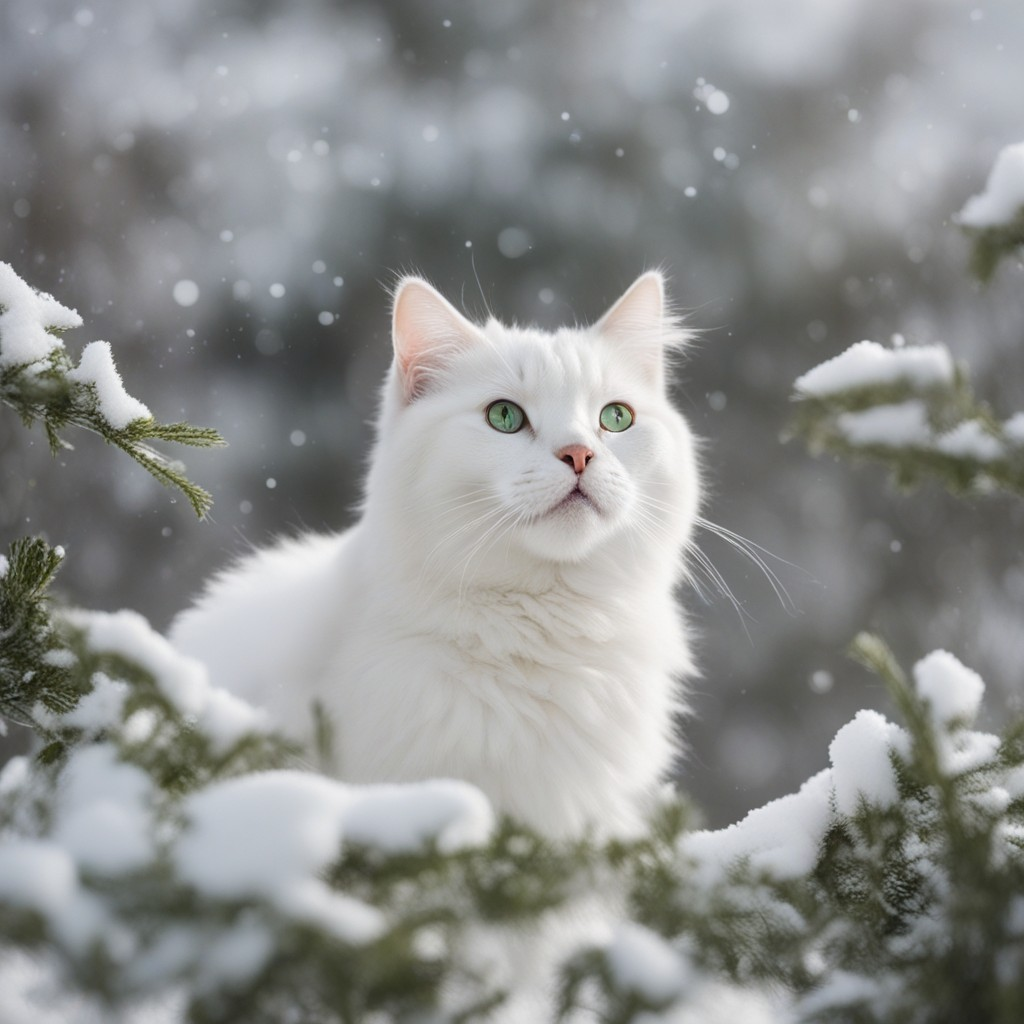

In [20]:
def to_pil_img(d):
    return Image.open(BytesIO(base64.b64decode(d.response_metadata.get("artifacts", [{}])[0].get("base64", ""))))


(img_gen | to_pil_img).invoke(
    "happy white cat with green eyes playing in the snow, high-quality artistic"
)

For more advanced or custom use-cases, you may be interested in leveraging the `NVEModel` client as a requests backbone. The `NVIDIAEmbeddings` and `ImageGetNVIDIA` classes are good starting points.

### **Usage/Cost Tracking**

For tracking model usage and , you can use the `get_usage_callback` context manager to track token information similar to `get_openai_callback`. Additionally, you can specify custom price mappings as necessary (`price_map` argument), or provide a custom callback manager for advanced use-cases (`callback` argument). 

**NOTE:** This feature is currently not supported in streaming modes, but works fine for non-streaming `invoke/ainvoke` queries. 

In [24]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

print(*ChatNVIDIA.get_available_models(mode="catalog", filter="mistralai"), sep="\n")
print(*NVIDIAEmbeddings.get_available_models(mode="catalog"), sep="\n")

id='mistralai/mistral-7b-instruct-v0.2' model_type='chat'
id='mistralai/mistral-large' model_type='chat'
id='mistralai/mixtral-8x22b-instruct-v0.1' model_type='chat'
id='mistralai/mixtral-8x7b-instruct-v0.1' model_type='chat'
id='nvidia/embed-qa-4' model_type='embedding'
id='snowflake/arctic-embed-l' model_type='embedding'


In [25]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain_nvidia_ai_endpoints.callbacks import get_usage_callback

## Assume a price map per 1K tokens for a particular deployment plan
price_map = {
    "mixtral_8x7b": 0.00060,
    "gemma_7b": 0.0002,
    "nvolveqa_40k": 0.000016,
} 

llm_large = ChatNVIDIA(model="mistralai/mixtral-8x22b-instruct-v0.1", temperature=0.1)
llm_small = ChatNVIDIA(model="mistralai/mistral-7b-instruct-v0.2", temperature=0.1)
embedding = NVIDIAEmbeddings(model="nvidia/embed-qa-4")
models = [llm_large, llm_small, embedding]

with get_usage_callback(price_map=price_map) as cb:
    ## Reset either at beginning or end. Statistics will run until cleared
    cb.reset()

    llm_large.invoke("Tell me a joke")
    print(cb, end="\n\n")
    # llm_large.invoke("Tell me a short joke")
    # print(cb, end="\n\n")
    # ## Tracking through streaming coming soon
    # [_ for _ in llm_small.stream("Tell me a joke")]
    # print(cb, end="\n[Should not change yet]\n\n")
    ## Tracking for streaming supported
    embedding.embed_query("What a nice day :D")
    print(cb, end="\n\n")
    # ## Sanity check. Should still be tracked fine
    # llm_small.invoke("Tell me a long joke")
    # print(cb, end="\n\n")

## Out of scope. Will not be tracked
llm_small.invoke("Tell me a short joke")
print(cb, end="\n[Should not change ever]\n\n")
cb.model_usage

Tokens Used: 23
	Prompt Tokens: 6
	Completion Tokens: 17
Successful Requests: 1
Total Cost (USD): $0



Exception: [404] Not Found
{'error': {'message': "The model 'nvidia/embed-qa-4' does not exist", 'type': 'invalid_request_error', 'param': 'model', 'code': 'model_not_found'}}

### Connecting To Other Services via `.mode`

In addition to connecting to the AI Foundation Endpoints, the same connector can be used to connect to other hosted endpoints and even local microservice instances like [**NeMo Inference Microservices (NIM)**]. Because of a built-in support for the OpenAPI specification standard, we can implement this kind of customization by simply switching out some endpoints and making sure we're passing around the right information. You can check out the `mode` method which switches over between different provider endpoints like NVIDIA AI Foundation Endpoints, NVIDIA API Catalog, OpenAI, and even local connection.

In [26]:
from getpass import getpass
import os

if not os.environ.get("OPENAI_API_KEY", "").startswith("sk-"):
    os.environ["OPENAI_API_KEY"] = getpass("OPENAI_API_KEY: ")

Note that this client is intended as a light-weight solution, so feel free to check the implementation and use the tricks above to customize the connector for your purposes. The connector is intentionally easy to modify and customize, and the implementation of `mode` should serve as a decent starting point!

In [28]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

# ChatNVIDIA().mode("nvidia").available_models  ## Actual default
# ChatNVIDIA.mode("nim", base_url="http://0.0.0.0:8000").available_models  ## Assumes nim is running
ChatNVIDIA().mode("openai").available_models  ## OpenAI Compatability

## NOTE: get_available_models is a class method that also exists. Requires specification of mode
# ChatNVIDIA().mode("openai").get_available_models()  ## Ignored mode
ChatNVIDIA().mode("openai").get_available_models(mode="openai")  ## OpenAI Compatability

[Model(id='gpt-4', model_type='chat'),
 Model(id='gpt-3.5-turbo-0125', model_type='chat'),
 Model(id='gpt-3.5-turbo-0301', model_type='chat'),
 Model(id='gpt-3.5-turbo-0613', model_type='chat'),
 Model(id='gpt-3.5-turbo-1106', model_type='chat'),
 Model(id='gpt-3.5-turbo-16k-0613', model_type='chat'),
 Model(id='gpt-3.5-turbo-16k', model_type='chat'),
 Model(id='gpt-3.5-turbo', model_type='chat'),
 Model(id='gpt-4-0125-preview', model_type='chat'),
 Model(id='gpt-4-0613', model_type='chat'),
 Model(id='gpt-4-1106-preview', model_type='chat'),
 Model(id='gpt-4-turbo-preview', model_type='chat'),
 Model(id='gpt-4-vision-preview', model_type='chat')]